# 1. 환경 설정 및 라이브러리 임포트트

In [ ]:
!pip install opencv-python-headless
!pip install torch torchvision
!pip install transformers
!pip install Pillow
!pip install tqdm

In [1]:
import os
import cv2
import json
import torch
from tqdm import tqdm
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. 비디오 파일 불러오기

In [10]:
video_folder = './Dataset'
video_files = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]

video_files = video_files[:1]
print(f"총 {len(video_files)}개의 비디오 파일을 발견했습니다.")

총 1개의 비디오 파일을 발견했습니다.


In [11]:
video_files

['video288.mp4']

## 3. 프레임 추출 함수 정의

In [12]:
def extract_frames(video_path, output_dir, frame_rate=1):
    """
    비디오 파일에서 프레임을 추출하여 저장합니다.

    Args:
        video_path (str): 비디오 파일 경로
        output_dir (str): 프레임 이미지 저장 디렉토리
        frame_rate (int): 초당 추출할 프레임 수
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"비디오 파일을 열 수 없습니다: {video_path}")
        return

    fps = round(cap.get(cv2.CAP_PROP_FPS))
    interval = int(fps / frame_rate) if fps > 0 else 1
    frame_count = 0
    saved_count = 0

    video_id = os.path.splitext(os.path.basename(video_path))[0]

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % interval == 0:
            timestamp = frame_count / fps if fps > 0 else frame_count
            frame_filename = f"{video_id}_{int(timestamp)}.jpg"
            frame_path = os.path.join(output_dir, frame_filename)
            cv2.imwrite(frame_path, frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"{video_id}: 추출된 프레임 수 = {saved_count}")

## 4. 프레임 추출 함수 실행

In [13]:
for video_file in tqdm(video_files, desc="비디오 프레임 추출 중"):
    video_path = os.path.join(video_folder, video_file)
    extract_frames(video_path, 'frames', frame_rate=1)  # 초당 1프레임 추출

비디오 프레임 추출 중: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

video288: 추출된 프레임 수 = 301


## 5. BLIP-2 모델 로드

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"사용 중인 디바이스: {device}")

MODEL_NAME = "OpenGVLab/InternVL2_5-1B"
#"Salesforce/blip2-flan-t5-xxl"  # 예시 (수GB ~ 수십GB)
# 또는 "Salesforce/blip2-llama2-13b", "Salesforce/blip2-opt-6.7b" 등등

print(f"[INFO] Loading BLIP-2 model: {MODEL_NAME}")

processor = Blip2Processor.from_pretrained(MODEL_NAME)
model = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
).eval()

사용 중인 디바이스: cuda
[INFO] Loading BLIP-2 model: OpenGVLab/InternVL2_5-1B


You are using a model of type internvl_chat to instantiate a model of type blip-2. This is not supported for all configurations of models and can yield errors.


ValueError: Trying to set a tensor of shape torch.Size([151674, 896]) in "weight" (which has shape torch.Size([50272, 768])), this looks incorrect.

## 6. 프레임에 대한 텍스트 생성

In [6]:
from googletrans import Translator
translator = Translator()

frames_folder = 'frames'
output_folder = 'output'

# 파일 이름에서 timestamp를 추출하여 정렬
def extract_timestamp(file_name):
    # 파일 이름 형식: videoid_timestamp.jpg
    try:
        # 'videoid_timestamp.jpg'에서 timestamp 부분을 추출
        timestamp_str = os.path.splitext(file_name)[0].rsplit('_', 1)[1]
        return int(timestamp_str)
    except (IndexError, ValueError):
        # 형식이 맞지 않거나, 변환이 불가능한 경우 큰 수를 반환하여 뒤로 정렬
        return float('inf')
    
frame_files = sorted(
    [f for f in os.listdir(frames_folder) if f.endswith('.jpg')],
    key=extract_timestamp
)

print(f"총 {len(frame_files)}개의 프레임 파일을 발견했습니다.")

results = []

for frame_file in tqdm(frame_files, desc="프레임에 텍스트 생성 중"):
    frame_path = os.path.join(frames_folder, frame_file)
    image = Image.open(frame_path).convert('RGB')

    inputs = processor(image, return_tensors="pt").to(device)

    with torch.no_grad():
        out = model.generate(**inputs)
    
    caption = processor.decode(out[0], skip_special_tokens=True)
    
    try:
        translation = translator.translate(caption, dest='ko')
        caption = translation.text
    except Exception as e:
        print(f"번역 실패: {caption}. 오류: {e}")
    
    # 결과 저장
    frame_id = os.path.splitext(frame_file)[0]
    try:
        video_id, timestamp = frame_id.rsplit('_', 1)
    except ValueError:
        video_id = frame_id
        timestamp = 0  # 또는 적절한 기본값 설정

    result = {
        "video_id": video_id,
        "timestamp": int(timestamp),
        "frame_image_path": frame_path,
        "caption": caption
    }
    results.append(result)

# JSON 파일로 저장
output_json_path = os.path.join(output_folder, "frame_captions.json")
with open(output_json_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

print(f"텍스트 생성 완료. 결과가 {output_json_path}에 저장되었습니다.")

총 149개의 프레임 파일을 발견했습니다.


프레임에 텍스트 생성 중: 100%|██████████| 149/149 [02:12<00:00,  1.12it/s]

텍스트 생성 완료. 결과가 output/frame_captions.json에 저장되었습니다.


## 7. 결과 확인

In [7]:
# JSON 파일 불러오기
with open(output_json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 첫 5개 결과 출력
for entry in data[:5]:
    print(f"비디오 ID: {entry['video_id']}, 타임스탬프: {entry['timestamp']}초")
    print(f"프레임 이미지: {entry['frame_image_path']}")
    print(f"캡션: {entry['caption']}\n")

비디오 ID: PaRrQhLYFSE, 타임스탬프: 0초
프레임 이미지: frames/PaRrQhLYFSE_0.jpg
캡션: 캡틴 아메리카 윈터 솔저의 게임 타이틀 화면

비디오 ID: PaRrQhLYFSE, 타임스탬프: 1초
프레임 이미지: frames/PaRrQhLYFSE_1.jpg
캡션: 캡틴 아메리카 윈터 솔저의 게임 타이틀 화면

비디오 ID: PaRrQhLYFSE, 타임스탬프: 2초
프레임 이미지: frames/PaRrQhLYFSE_2.jpg
캡션: 캡틴 아메리카 윈터 솔저의 게임 타이틀 화면

비디오 ID: PaRrQhLYFSE, 타임스탬프: 3초
프레임 이미지: frames/PaRrQhLYFSE_3.jpg
캡션: 캡틴 아메리카 윈터 솔저의 게임 타이틀 화면

비디오 ID: PaRrQhLYFSE, 타임스탬프: 4초
프레임 이미지: frames/PaRrQhLYFSE_4.jpg
캡션: 캡틴 아메리카 윈터 솔저의 게임 타이틀 화면



## 8. TTF 함수 정의

In [8]:
import json
from collections import Counter
import re
from nltk.corpus import stopwords
from konlpy.tag import Okt

# 형태소 분석기 초기화
okt = Okt()

def load_captions(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

# def preprocess_text(text):
#     """
#     한국어 텍스트 전처리 함수: 특수문자 제거, 형태소 분석, 불용어 제거
#     Args:
#         text (str): 원본 한국어 텍스트
#     Returns:
#         list: 전처리된 단어 리스트
#     """
#     # 특수문자 및 숫자 제거
#     text = re.sub(r'[^\w\s]', '', text)
#     # 형태소 분석을 통해 단어 분리
#     words = okt.morphs(text, stem=True)
#     # 불용어 목록 (필요에 따라 확장 가능)
#     stop_words = set(["을", "를", "에", "은", "의", "있다", "는", "이", "가", "도", "한", "하다"])
#     # 불용어 제거
#     meaningful_words = [word for word in words if word not in stop_words]
    
#     return meaningful_words

def preprocess_text(text):
    """
    한국어 텍스트 전처리 함수: 특수문자 제거, 명사 추출, 불용어 제거

    Args:
        text (str): 원본 한국어 텍스트

    Returns:
        list: 전처리된 명사 리스트
    """
    # 특수문자 및 숫자 제거
    text = re.sub(r'[^\w\s]', '', text)
    
    # 명사 추출
    nouns = okt.nouns(text)
    
    # 불용어 목록 (필요에 따라 확장 가능)
    stop_words = set(["을", "를", "에", "은", "의", "있다", "는", "이", "가", "도", "한", "하다"])
    
    # 불용어 제거
    meaningful_nouns = [noun for noun in nouns if noun not in stop_words]
    
    return meaningful_nouns

def count_word_frequencies(data):
    all_words = []
    for entry in tqdm(data, desc="단어 빈도 계산 중"):
        caption = entry['caption']
        words = preprocess_text(caption)
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    top_10 = word_counts.most_common(10)
    top_10_words = [word for word, count in top_10]
    
    print("상위 10개 유의미한 단어:")
    for word, count in top_10:
        print(f"{word}: {count}번")
    
    return top_10_words

# def search_frames(data, input_words):
#     results = {}
#     for word in input_words:
#         best_match = None
#         max_count = 0
#         for entry in data:
#             caption = entry['caption']
#             words = preprocess_text(caption)
#             count = words.count(word)
#             if count > max_count:
#                 max_count = count
#                 best_match = entry
#         if best_match:
#             results[word] = best_match
#     return results

def search_best_frame(data, input_words):
    """
    상위 10개 명사들과 가장 많이 매칭되는 단일 프레임을 선택합니다.
    
    Args:
        data (list): JSON 데이터 리스트
        input_words (list): 상위 10개 명사 리스트
    
    Returns:
        dict: 선택된 프레임 정보 딕셔너리
    """
    best_frame = None
    best_score = 0
    
    for entry in tqdm(data, desc="프레임 점수 계산 중"):
        caption = entry.get('caption', '')
        if not caption:
            continue
        nouns = preprocess_text(caption)
        # 입력 단어들과 일치하는 명사의 총 개수를 점수로 사용
        score = sum([nouns.count(word) for word in input_words])
        if score > best_score:
            best_score = score
            best_frame = entry
    
    return best_frame

def display_frame(frame_entry):
    image_path = frame_entry['frame_image_path']
    if os.path.exists(image_path):
        try:
            image = Image.open(image_path)
            image.show()
        except Exception as e:
            print(f"이미지를 열 수 없습니다: {image_path}. 오류: {e}")
    else:
        print(f"이미지 파일이 존재하지 않습니다: {image_path}")


JSON 파일을 불러오는 중...
총 149개의 프레임 데이터가 로드되었습니다.



단어 빈도 계산 중: 100%|██████████| 149/149 [00:04<00:00, 35.12it/s]


상위 10개 유의미한 단어:
게임: 128번
비디오: 80번
남자: 72번
화면: 54번
건물: 41번
스크린샷: 35번
위: 22번
앞: 22번
사람: 19번
도시: 18번


프레임을 검색하는 중...


프레임 점수 계산 중: 100%|██████████| 149/149 [00:00<00:00, 755.10it/s]



프레임 검색 완료.

선택된 프레임이 매칭된 단어들: 게임, 비디오, 건물, 스크린샷, 앞, 사람
비디오 ID: PaRrQhLYFSE, 타임스탬프: 22초
프레임 이미지: frames/PaRrQhLYFSE_22.jpg
캡션: 건물 앞에 두 사람이 있는 비디오 게임의 스크린샷



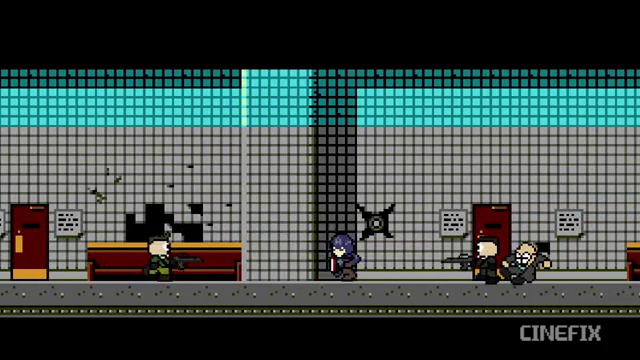

In [9]:
# 1. JSON 파일 로드
json_path = 'output/frame_captions.json'
print("JSON 파일을 불러오는 중...")
data = load_captions(json_path)
print(f"총 {len(data)}개의 프레임 데이터가 로드되었습니다.\n")

# 2. 상위 10개 유의미한 단어 추출
top_10_words = count_word_frequencies(data)
print("\n")

# 3. 프레임 검색
print("프레임을 검색하는 중...")
best_frame = search_best_frame(data, top_10_words)
print("\n프레임 검색 완료.\n")

# 4. 검색 결과 출력 및 이미지 표시
if best_frame:
        word_matches = [word for word in top_10_words if word in preprocess_text(best_frame.get('caption', ''))]
        print(f"선택된 프레임이 매칭된 단어들: {', '.join(word_matches)}")
        print(f"비디오 ID: {best_frame.get('video_id', '알 수 없음')}, 타임스탬프: {best_frame.get('timestamp', '알 수 없음')}초")
        print(f"프레임 이미지: {best_frame.get('frame_image_path', '알 수 없음')}")
        print(f"캡션: {best_frame.get('caption', '알 수 없음')}\n")
        
        # 이미지 표시
        display_frame(best_frame)
else:
    print("상위 10개 명사와 매칭되는 프레임이 없습니다.")

---
## 마무리
이 노트북을 통해,
- BLIP-2 대형 모델로 프레임별 캡션 → **Video to Text**
과정을 시연했습니다.

실제 **여러 영상**(예: 360개)에 적용하려면,
- (1) Video ID 목록을 반복하면서 다운로드
- (2) 각 파일에 대해 `video_to_text` 수행 (멀티프로세싱, 분산처리 가능)
등으로 확장하면 됩니다.

**주의**: 대형 모델 로딩 시 **수십 GB 메모리**가 필요할 수 있으니, 
적절한 GPU/CPU 환경에서 진행하시길 권장합니다.